In [ ]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# Explain PyTextRank: the algorithm

Let's look at the *TextRank* algorithm used to build a graph from a raw text, and then from that extract the top-ranked phrases. This work is based on 
["TextRank: Bringing Order into Text"](http://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf),
Rada Mihalcea, Paul Tarau, _Empirical Methods in Natural Language Processing_ (2004).

---
First we perform some basic housekeeping for Jupyter, then load `spaCy` with a language model for English ...

In [2]:
from icecream import ic
import warnings
warnings.filterwarnings("ignore")

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

Now, to get started, we'll create some text to use.

In [4]:
#text = "When Ada was twelve years old, this future 'Lady Fairy', as Charles Babbage affectionately called her, decided she wanted to fly. Ada Byron went about the project methodically, thoughtfully, with imagination and passion. Her first step, in February 1828, was to construct wings. She investigated different material and sizes. She considered various materials for the wings: paper, oilsilk, wires, and feathers. She examined the anatomy of birds to determine the right proportion between the wings and the body. She decided to write a book, Flyology, illustrating, with plates, some of her findings. She decided what equipment she would need; for example, a compass, to 'cut across the country by the most direct road', so that she could surmount mountains, rivers, and valleys. Her final step was to integrate steam with the 'art of flying."

text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types."

doc = nlp(text)

How many sentences are in the parsed document and where are their boundaries?

In [5]:
for sent in doc.sents:
    ic(sent.start, sent.end)

ic| sent.start: 0, sent.end: 13
ic| sent.start: 13, sent.end: 33
ic| sent.start: 33, sent.end: 61
ic| sent.start: 61, sent.end: 91


What are the raw _noun chunks_ in the parsed document?

In [6]:
for chunk in doc.noun_chunks:
    ic(chunk.text)

ic| chunk.text: 'Compatibility'
ic| chunk.text: 'systems'
ic| chunk.text: 'linear constraints'
ic| chunk.text: 'the set'
ic| chunk.text: 'natural numbers'
ic| chunk.text: 'Criteria'
ic| chunk.text: 'compatibility'
ic| chunk.text: 'a system'
ic| chunk.text: 'linear Diophantine equations'
ic| chunk.text: 'strict inequations'
ic| chunk.text: 'nonstrict inequations'
ic| chunk.text: 'Upper bounds'
ic| chunk.text: 'components'
ic| chunk.text: 'a minimal set'
ic| chunk.text: 'solutions'
ic| chunk.text: 'algorithms'
ic| chunk.text: 'construction'
ic| chunk.text: 'minimal generating sets'
ic| chunk.text: 'solutions'
ic| chunk.text: 'all types'
ic| chunk.text: 'systems'
ic| chunk.text: 'These criteria'
ic| chunk.text: 'the corresponding algorithms'
ic| chunk.text: 'a minimal supporting set'
ic| chunk.text: 'solutions'
ic| chunk.text: 'all the considered types systems'
ic| chunk.text: 'systems'
ic| chunk.text: 'mixed types'


Also, does `spaCy` detect any _named entities_? (probably not, given this example text input)

In [7]:
for ent in doc.ents:
    ic(ent.text, ent.label_, ent.start, ent.end)

Given those details about the parsed document, next we use [NetworkX](https://networkx.github.io/) to manage an in-memory graph...

In [8]:
import networkx as nx

def increment_edge (graph, node0, node1):
    print("link {} {}".format(node0, node1))
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

Then construct a graph, sentence by sentence, based on the [spaCy part-of-speech tags](https://spacy.io/api/annotation#pos-en) tags:

In [9]:
POS_KEPT = ["ADJ", "NOUN", "PROPN", "VERB"]

def link_sentence (doc, sent, lemma_graph, seen_lemma):
    visited_tokens = []
    visited_nodes = []

    for i in range(sent.start, sent.end):
        token = doc[i]

        if token.pos_ in POS_KEPT:
            key = (token.lemma_, token.pos_)

            if key not in seen_lemma:
                seen_lemma[key] = set([token.i])
            else:
                seen_lemma[key].add(token.i)

            node_id = list(seen_lemma.keys()).index(key)

            if not node_id in lemma_graph:
                lemma_graph.add_node(node_id)

            ic("visit {} {}".format(visited_tokens, visited_nodes))
            ic("range {}".format(list(range(len(visited_tokens) - 1, -1, -1))))
            
            for prev_token in range(len(visited_tokens) - 1, -1, -1):
                ic("prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])))
                
                if (token.i - visited_tokens[prev_token]) <= 3:
                    increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
                else:
                    break

            ic(token.i, token.text, token.lemma_, token.pos_, visited_tokens, visited_nodes)

            visited_tokens.append(token.i)
            visited_nodes.append(node_id)

Now iterate through the sentences to construct the lemma graph...

In [10]:
lemma_graph = nx.Graph()
seen_lemma = {}

for sent in doc.sents:
    link_sentence(doc, sent, lemma_graph, seen_lemma)
    #break # only test one sentence

ic(seen_lemma)

ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [] []'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range []'
ic| token.i: 0
    token.text: 'Compatibility'
    token.lemma_: 'compatibility'
    token.pos_: 'NOUN'
    visited_tokens: []
    visited_nodes: []
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [0] [0]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 0 2'
ic| token.i: 2
    token.text: 'systems'
    token.lemma_: 'system'
    token.pos_: 'NOUN'
    visited_tokens: [0]
    visited_nodes: [0]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [0, 2] [0, 1]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): '

link 1 0


prev_tok 1 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 0 4'
ic| token.i: 4
    token.text: 'linear'
    token.lemma_: 'linear'
    token.pos_: 'ADJ'
    visited_tokens: [0, 2]
    visited_nodes: [0, 1]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [0, 2, 4] [0, 1, 2]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])):

link 2 1


 'prev_tok 2 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 1 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 0 5'
ic| token.i: 5
    token.text: 'constraints'
    token.lemma_: 'constraint'
    token.pos_: 'NOUN'
    visited_tokens: [0, 2, 4]
    visited_nodes: [0, 1, 2]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [0, 2, 4, 5] [0, 1, 2, 3]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, 

link 3 2
link 3 1


-1))): 'range [3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 3 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 2 4'
ic| token.i: 8
    token.text: 'set'
    token.lemma_: 'set'
    token.pos_: 'NOUN'
    visited_tokens: [0, 2, 4, 5]
    visited_nodes: [0, 1, 2, 3]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [0, 2, 4, 5, 8] [0, 1, 2, 3, 4]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): '

link 4 3


prev_tok 4 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 3 5'
ic| token.i: 10
    token.text: 'natural'
    token.lemma_: 'natural'
    token.pos_: 'ADJ'
    visited_tokens: [0, 2, 4, 5, 8]
    visited_nodes: [0, 1, 2, 3, 4]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [0, 2, 4, 5, 8, 10] [0, 1, 2, 3, 4, 5]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.

link 5 4


i - visited_tokens[prev_token])): 'prev_tok 5 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 4 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 3 6'
ic| token.i: 11
    token.text: 'numbers'
    token.lemma_: 'number'
    token.pos_: 'NOUN'
    visited_tokens: [0, 2, 4, 5, 8, 10]
    visited_nodes: [0, 1, 2, 3, 4, 5]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [] []'


link 6 5
link 6 4


ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range []'
ic| token.i: 13
    token.text: 'Criteria'
    token.lemma_: 'criterion'
    token.pos_: 'NOUN'
    visited_tokens: []
    visited_nodes: []
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [13] [7]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 0 2'
ic| token.i: 15
    token.text: 'compatibility'
    token.lemma_: 'compatibility'
    token.pos_: 'NOUN'
    visited_tokens: [13]
    visited_nodes: [7]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [13, 15] [7, 0]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 1 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token]))

link 0 7
link 1 0


: 'prev_tok 0 5'
ic| token.i: 18
    token.text: 'system'
    token.lemma_: 'system'
    token.pos_: 'NOUN'
    visited_tokens: [13, 15]
    visited_nodes: [7, 0]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [13, 15, 18] [7, 0, 1]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 2 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 1 5'
ic| token.i: 20
    token.text: 'linear'
    token.lemma_: 'linear'
    token.pos_: 'ADJ'
    visited_tokens: [13, 15, 18]
    visited_nodes: [7, 0, 1]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [13, 15, 18, 20] [7, 0, 1, 2]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token]

link 2 1


)): 'prev_tok 3 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 2 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 1 6'
ic| token.i: 21
    token.text: 'Diophantine'
    token.lemma_: 'Diophantine'
    token.pos_: 'PROPN'
    visited_tokens: [13, 15, 18, 20]
    visited_nodes: [7, 0, 1, 2]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [13, 15, 18, 20, 21] [7, 0, 1, 2, 8]'
ic| "range {}

link 8 2
link 8 1


".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 4 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 3 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 2 4'
ic| token.i: 22
    token.text: 'equations'
    token.lemma_: 'equation'
    token.pos_: 'NOUN'
    visited_tokens: [13, 15, 18, 20, 21]
    visited_nodes: [7, 0, 1, 2, 8]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [13, 15, 18, 20, 21, 22] [7, 0, 1, 2, 8, 9]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, 

link 9 8
link 9 2


-1))): 'range [5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 5 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 4 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 3 4'
ic| token.i: 24
    token.text: 'strict'
    token.lemma_: 'strict'
    token.pos_: 'ADJ'
    visited_tokens: [13, 15, 18, 20, 21, 22]
    visited_nodes: [7, 0, 1, 2, 8, 9]
ic| "visit {} {}".format(visited_tokens, visited_nodes): '

link 10 9
link 10 8


visit [13, 15, 18, 20, 21, 22, 24] [7, 0, 1, 2, 8, 9, 10]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 6 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 5 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 4 4'
ic| token.i: 25
    token.text: 'inequations'
    token.lemma_: 'inequation'
    token.pos_: 'NOUN'
    visited_tokens: [13, 15, 18, 20, 21, 22, 24]
    visited_nodes: [7, 0, 1, 2, 8, 9, 10]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [13, 15, 18, 20, 21, 22, 24, 25] [7, 0, 1, 2, 8, 9, 10, 11]'
ic| "range {}".format(list(range(

link 11 10
link 11 9


len(visited_tokens) - 1, -1, -1))): 'range [7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 7 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 6 4'
ic| token.i: 28
    token.text: 'nonstrict'
    token.lemma_: 'nonstrict'
    token.pos_: 'ADJ'
    visited_tokens: [13, 15, 18, 20, 21, 22, 24, 25]
    visited_nodes: [7, 0, 1, 2, 8, 9, 10, 11]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [13, 15, 18, 20, 21, 22, 24, 25, 28] [7, 0, 1, 2, 8, 9, 10, 11, 12]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}

link 12 11


".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 8 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 7 4'
ic| token.i: 29
    token.text: 'inequations'
    token.lemma_: 'inequation'
    token.pos_: 'NOUN'
    visited_tokens: [13, 15, 18, 20, 21, 22, 24, 25, 28]
    visited_nodes: [7, 0, 1, 2, 8, 9, 10, 11, 12]
ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [13, 15, 18, 20, 21, 22, 24, 25, 28, 29] [7, 0, 1, 2, 8, 9, 10, 11, '
                                                          '12, 11]')
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'


link 11 12


ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 9 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 8 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 7 6'
ic| token.i: 31
    token.text: 'considered'
    token.lemma_: 'consider'
    token.pos_: 'VERB'
    visited_tokens: [13, 15, 18, 20, 21, 22, 24, 25, 28, 29]
    visited_nodes: [7, 0, 1, 2, 8, 9, 10, 11, 12, 11]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [] []'

link 13 11
link 13 12



ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range []'
ic| token.i: 33
    token.text: 'Upper'
    token.lemma_: 'upper'
    token.pos_: 'ADJ'
    visited_tokens: []
    visited_nodes: []
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [33] [14]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 0 1'
ic| token.i: 34
    token.text: 'bounds'
    token.lemma_: 'bound'
    token.pos_: 'NOUN'
    visited_tokens: [33]
    visited_nodes: [14]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [33, 34] [14, 15]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 1 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])):

link 15 14
link 16 15


 'prev_tok 0 3'
ic| token.i: 36
    token.text: 'components'
    token.lemma_: 'component'
    token.pos_: 'NOUN'
    visited_tokens: [33, 34]
    visited_nodes: [14, 15]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [33, 34, 36] [14, 15, 16]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 2 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 1 5'

link 16 14
link 17 16



ic| token.i: 39
    token.text: 'minimal'
    token.lemma_: 'minimal'
    token.pos_: 'ADJ'
    visited_tokens: [33, 34, 36]
    visited_nodes: [14, 15, 16]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [33, 34, 36, 39] [14, 15, 16, 17]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 3 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 2 4'
ic| token.i: 40
    token.text: 'set'
    token.lemma_: 'set'
    token.pos_: 'NOUN'
    visited_tokens: [33, 34, 36, 39]
    visited_nodes: [14, 15, 16, 17]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [33, 34, 36, 39, 40] [14, 15, 16, 17, 4]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - 

link 4 17


visited_tokens[prev_token])): 'prev_tok 4 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 3 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 2 6'
ic| token.i: 42
    token.text: 'solutions'
    token.lemma_: 'solution'
    token.pos_: 'NOUN'
    visited_tokens: [33, 34, 36, 39, 40]
    visited_nodes: [14, 15, 16, 17, 4]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [33, 34, 36, 39, 40, 42] [14, 15, 16, 17, 4, 18]'
ic| "range {}".format(list(range(len(visited_tokens)

link 18 4
link 18 17


 - 1, -1, -1))): 'range [5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 5 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 4 4'
ic| token.i: 44
    token.text: 'algorithms'
    token.lemma_: 'algorithm'
    token.pos_: 'NOUN'
    visited_tokens: [33, 34, 36, 39, 40, 42]
    visited_nodes: [14, 15, 16, 17, 4, 18]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [33, 34, 36, 39, 40, 42, 44] [14, 15, 16, 17, 4, 18, 19]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token]))

link 19 18


: 'prev_tok 6 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 5 4'
ic| token.i: 46
    token.text: 'construction'
    token.lemma_: 'construction'
    token.pos_: 'NOUN'
    visited_tokens: [33, 34, 36, 39, 40, 42, 44]
    visited_nodes: [14, 15, 16, 17, 4, 18, 19]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [33, 34, 36, 39, 40, 42, 44, 46] [14, 15, 16, 17, 4, 18, 19, 20]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok 

link 20 19


{} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 7 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 6 4'
ic| token.i: 48
    token.text: 'minimal'
    token.lemma_: 'minimal'
    token.pos_: 'ADJ'
    visited_tokens: [33, 34, 36, 39, 40, 42, 44, 46]
    visited_nodes: [14, 15, 16, 17, 4, 18, 19, 20]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [33, 34, 36, 39, 40, 42, 44, 46, 48] [14, 15, 16, 17, 4, 18, 19, 20, 17]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| 

link 17 20


"prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 8 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 7 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 6 5'
ic| token.i: 49
    token.text: 'generating'
    token.lemma_: 'generate'
    token.pos_: 'VERB'
    visited_tokens: [33, 34, 36, 39, 40, 42, 44, 46, 48]
    visited_nodes: [14, 15, 16, 17, 4, 18, 19, 20, 17]

link 21 17
link 21 20



ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [33, 34, 36, 39, 40, 42, 44, 46, 48, 49] [14, 15, 16, 17, 4, 18, 19, '
                                                          '20, 17, 21]')
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 9 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 8 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 7 4'
ic| token.i: 50
    token.text: 'sets'
    token.lemma_: 'set'
    token.pos_: 'NOUN'
    visited_tokens: [33, 34, 36, 39, 40, 42, 44, 46, 48, 49]
    visited_nodes: [14, 15, 16, 17,

link 4 21
link 4 17


 4, 18, 19, 20, 17, 21]
ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [33, 34, 36, 39, 40, 42, 44, 46, 48, 49, 50] [14, 15, 16, 17, 4, 18, '
                                                          '19, 20, 17, 21, 4]')
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 10 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 9 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 8 4'
ic| token.i: 52
    token.text: 'solutions'
    token.lemma_: 'solution'
    token.pos_: 'NOUN'
    visited_tokens: [33, 34, 36, 39, 40, 42, 44, 46, 48, 49, 50]
    visited_nodes: [14, 15

link 18 4
link 18 21


, 16, 17, 4, 18, 19, 20, 17, 21, 4]
ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [33, 34, 36, 39, 40, 42, 44, 46, 48, 49, 50, 52] [14, 15, 16, 17, 4, '
                                                          '18, 19, 20, 17, 21, 4, 18]')
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 11 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 10 5'
ic| token.i: 55
    token.text: 'types'
    token.lemma_: 'type'
    token.pos_: 'NOUN'
    visited_tokens: [33, 34, 36, 39, 40, 42, 44, 46, 48, 49, 50, 52]
    visited_nodes: [14, 15, 16, 17, 4, 18, 19, 20, 17, 21, 4, 18]
ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [33, 34, 36, 39, 40, 42, 44, 46, 48, 49, 50, 52, 55] [14, 15, 16, 17, '
                                                          '4, 18, 19, 

link 22 18


range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 12 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 11 5'
ic| token.i: 57
    token.text: 'systems'
    token.lemma_: 'system'
    token.pos_: 'NOUN'
    visited_tokens: [33, 34, 36, 39, 40, 42, 44, 46, 48, 49, 50, 52, 55]
    visited_nodes: [14, 15, 16, 17, 4, 18, 19, 20, 17, 21, 4, 18, 22]
ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [33, 34, 36, 39, 40, 42, 44, 46, 48, 49, 50, 52, 55, 57] [14, 15, 16, 

link 1 22


'
                                                          '17, 4, 18, 19, 20, 17, 21, 4, 18, 22, 1]')
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 13 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 12 4'
ic| token.i: 59
    token.text: 'given'
    token.lemma_: 'give'
    token.pos_: 'VERB'
    visited_tokens: [33, 34, 36, 39, 40, 42, 44, 46, 48, 49, 50, 52, 55, 57]
    visited_nodes: [14

link 23 1


, 15, 16, 17, 4, 18, 19, 20, 17, 21, 4, 18, 22, 1]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [] []'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range []'
ic| token.i: 62
    token.text: 'criteria'
    token.lemma_: 'criterion'
    token.pos_: 'NOUN'
    visited_tokens: []
    visited_nodes: []
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [62] [7]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 0 3'
ic| token.i: 65
    token.text: 'corresponding'
    token.lemma_: 'correspond'
    token.pos_: 'VERB'
    visited_tokens: [62]
    visited_nodes: [7]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [62, 65] [7, 24]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i

link 24 7


 - visited_tokens[prev_token])): 'prev_tok 1 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])
    token.text: 'constructing'
    token.lemma_: 'construct'
    token.pos_: 'VERB'
    visited_tokens: [62, 65, 66]
    visited_nodes: [7, 24, 19]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [62, 65, 66, 68] [7, 24, 19, 25]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1,

link 25 19
link 25 24


 -1))): 'range [3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 3 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 2 4'
ic| token.i: 70
    token.text: 'minimal'
    token.lemma_: 'minimal'
    token.pos_: 'ADJ'
    visited_tokens: [62, 65, 66, 68]
    visited_nodes: [7, 24, 19, 25]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [62, 65, 66, 68, 70] [7, 24, 19, 25, 17]'
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format

link 17 25


(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 4 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 3 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 2 5'
ic| token.i: 71
    token.text: 'supporting'
    token.lemma_: 'support'
    token.pos_: 'VERB'
    visited_tokens: [62, 65, 66, 68, 70]
    visited_nodes: [7, 24, ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 5 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 4 4'
ic| token.i: 74
    token.text: 'solutions'
    token.lemma_: 'solution'
    token.pos_: 'NOUN'
    visited_tokens: [62, 65, 66, 68, 70, 71, 72]
    visited_nodes: [7, 24, 19, 25, 17, 26, 4]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [62, 65, 66, 68, 70, 71, 72, 74] [7, 24, 19, 25, 17, 26, 4, 18]'


link 18 4
link 18 26


ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 7 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 6 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 5 4'
ic| token.i: 75
    token.text: 'can'
    token.lemma_: 'can'
    token.pos_: 'VERB'
    visited_tokens: [62, 65, 66, 68, 70, 71, 72, 74]
    visited_nodes: [7, 24, 19, 25, 17, 26, 4, 18]
ic| "visit {} {}".format(visited_tokens, visited_nodes): 'visit [62, 65, 66, 68, 70, 71, 72, 74, 75] [7, 24, 19, 25, 17, 26, 4, 18, 27]'


link 27 18
link 27 4


ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token,: 'VERB'
    visited_tokens: [62, 65, 66, 68, 70, 71, 72, 74, 75, 77]
    visited_nodes: [7, 24, 19, 25, 17, 26, 4, 18, 27, 28]
ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79] [7, 24, 19, 25, 17, 26, '
                                                          '4, 18, 27, 28, 29]'

link 29 28


)
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 10 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 9 5'
ic| token.i: 82
    token.text: 'considered'
    token.lemma_: 'consider'
    token.pos_: 'VERB'
    visited_tokens: [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79]
    visited_nodes: [7, 24, 19, 25, 17, 26, 4, 18, 27, 28, 29]
ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79, 82] [7, 24, 19, 25, 17, '
                                                          '26, 4, 18, 27, 28, 29, 13]')
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1)

link 13 29


)): 'range [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 11 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 10 4'
ic| token.i: 83
    token.text: 'types'
    token.lemma_: 'type'
    token): 'prev_tok 11 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 10 5'
ic| token.i: 84
    token.text: 'systems'
    token.lemma_: 'system'
    token.pos_: 'NOUN'
    visited_tokens: [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79, 82, 83]
    visited_nodes: [7, 24, 19, 25, 17, 26, 4, 18, 27, 28, 29, 13, 22]


link 1 22
link 1 13


ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79, 82, 83, 84] [7, 24, 19, '
                                                          '25, 17, 26, 4, 18, 27, 28, 29, 13, 22, 1]')
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 13 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 12 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 11 4'
ic| token.i: 86
    token.text: 'systems'
    token.lemma_: 'system'
    token.pos_: 'NOUN'
    visited_tokens: [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79, 82, 83, 84]
    visited_nodes: [7, 24, 19, 25, 17, 26, 4, 18, 27, 28, 29, 13, 22, 1]


link 1 1
link 1 22


ic| "visit {} {}".format(visited_tokens, visited_nodes): ('visit [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79, 82, 83, 84, 86] [7, 24, '
                                                          '19, 25, 17, 26, 4, 18, 27, 28, 29, 13, 22, 1, 1]')
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 14 2'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 13 4'
ic| token.i: 88
    token.text: 'mixed'
    token.lemma_: 'mixed'
    token.pos_: 'ADJ'
    visited_tokens: [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79, 82, 83, 84, 86]
    visited_nodes: [7, 24, 19, 25, 17, 26, 4, 18, 27, 28, 29, 13, 22, 1, 1]
ic| "visit {} {}".

link 30 1


format(visited_tokens, visited_nodes): ('visit [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79, 82, 83, 84, 86, 88] [7, '
                                                          '24, 19, 25, 17, 26, 4, 18, 27, 28, 29, 13, 22, 1, 1, 30]')
ic| "range {}".format(list(range(len(visited_tokens) - 1, -1, -1))): 'range [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 15 1'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 14 3'
ic| "prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])): 'prev_tok 13 5'
ic| token.i: 89
    token.text: 'types'
    token.lemma_: 'type'
    token.pos_: 'NOUN'
    visited_tokens: [62, 65, 66, 68, 70, 71, 72, 74, 75, 77, 79, 82, 83, 84, 86, 88]
    visited_nodes: [7, 24, 19, 25, 17, 26, 4, 18, 27, 28, 29, 13

link 22 30
link 22 1


, 22, 1, 1, 30]
ic| seen_lemma: {('Diophantine', 'PROPN'): {21},
                 ('algorithm', 'NOUN'): {66, 44},
                 ('bound', 'NOUN'): {34},
                 ('can', 'VERB'): {75},
                 ('compatibility', 'NOUN'): {0, 15},
                 ('component', 'NOUN'): {36},
                 ('consider', 'VERB'): {82, 31},
                 ('constraint', 'NOUN'): {5},
                 ('construct', 'VERB'): {68},
                 ('construction', 'NOUN'): {46},
                 ('correspond', 'VERB'): {65},
                 ('criterion', 'NOUN'): {13, 62},
                 ('equation', 'NOUN'): {22},
                 ('generate', 'VERB'): {49},
                 ('give', 'VERB'): {59},
                 ('inequation', 'NOUN'): {25, 29},
                 ('linear', 'ADJ'): {4, 20},
                 ('minimal', 'ADJ'): {48, 70, 39},
                 ('mixed', 'ADJ'): {88},
                 ('natural', 'ADJ'): {10},
                 ('nonstrict', 'ADJ'): {28},
          

{('compatibility', 'NOUN'): {0, 15},
 ('system', 'NOUN'): {2, 18, 57, 84, 86},
 ('linear', 'ADJ'): {4, 20},
 ('constraint', 'NOUN'): {5},
 ('set', 'NOUN'): {8, 40, 50, 72},
 ('natural', 'ADJ'): {10},
 ('number', 'NOUN'): {11},
 ('criterion', 'NOUN'): {13, 62},
 ('Diophantine', 'PROPN'): {21},
 ('equation', 'NOUN'): {22},
 ('strict', 'ADJ'): {24},
 ('inequation', 'NOUN'): {25, 29},
 ('nonstrict', 'ADJ'): {28},
 ('consider', 'VERB'): {31, 82},
 ('upper', 'ADJ'): {33},
 ('bound', 'NOUN'): {34},
 ('component', 'NOUN'): {36},
 ('minimal', 'ADJ'): {39, 48, 70},
 ('solution', 'NOUN'): {42, 52, 74},
 ('algorithm', 'NOUN'): {44, 66},
 ('construction', 'NOUN'): {46},
 ('generate', 'VERB'): {49},
 ('type', 'NOUN'): {55, 83, 89},
 ('give', 'VERB'): {59},
 ('correspond', 'VERB'): {65},
 ('construct', 'VERB'): {68},
 ('support', 'VERB'): {71},
 ('can', 'VERB'): {75},
 ('use', 'VERB'): {77},
 ('solve', 'VERB'): {79},
 ('mixed', 'ADJ'): {88}}

Let's visualize the lemma graph, and for that first we need to collect a dictionary of the labels.

In [11]:
labels = {}
keys = list(seen_lemma.keys())

for i in range(len(seen_lemma)):
    labels[i] = keys[i][0].lower()

labels

{0: 'compatibility',
 1: 'system',
 2: 'linear',
 3: 'constraint',
 4: 'set',
 5: 'natural',
 6: 'number',
 7: 'criterion',
 8: 'diophantine',
 9: 'equation',
 10: 'strict',
 11: 'inequation',
 12: 'nonstrict',
 13: 'consider',
 14: 'upper',
 15: 'bound',
 16: 'component',
 17: 'minimal',
 18: 'solution',
 19: 'algorithm',
 20: 'construction',
 21: 'generate',
 22: 'type',
 23: 'give',
 24: 'correspond',
 25: 'construct',
 26: 'support',
 27: 'can',
 28: 'use',
 29: 'solve',
 30: 'mixed'}

Then use `matplotlib` to visualize the lemma graph:

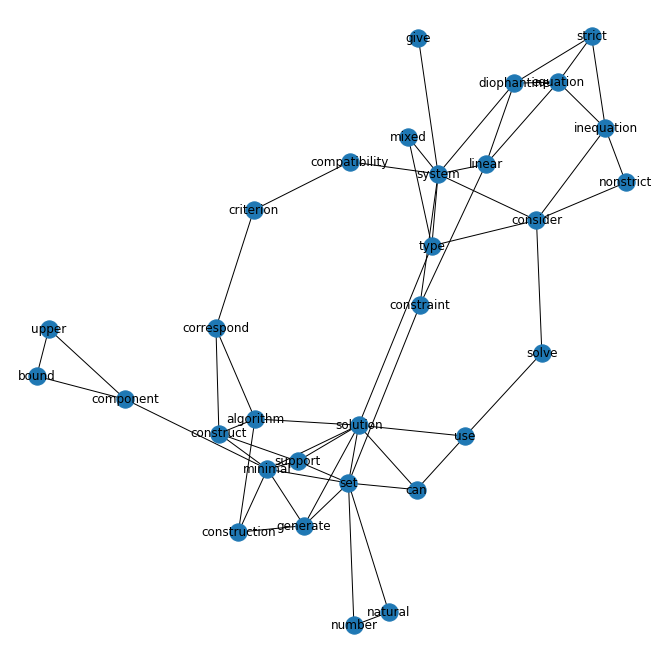

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 9))
pos = nx.spring_layout(lemma_graph)

nx.draw(lemma_graph, pos=pos, with_labels=False, font_weight="bold")
nx.draw_networkx_labels(lemma_graph, pos, labels);

Now to run the algorithm, we use `PageRank` – which is approximately _eigenvalue centrality_ – to calculate ranks for each of the nodes in the lemma graph.

In [13]:
ranks = nx.pagerank(lemma_graph)
ranks

{0: 0.024271712355906368,
 1: 0.09333252040998133,
 2: 0.03523397804162026,
 3: 0.02206335459191633,
 4: 0.07861554068010741,
 5: 0.01809941577235555,
 6: 0.018099415772355555,
 7: 0.019060006636093224,
 8: 0.029808750669594285,
 9: 0.03048048654757325,
 10: 0.024130822879014753,
 11: 0.038123234125218,
 12: 0.0241093059622507,
 13: 0.03711169419801581,
 14: 0.023451020703587552,
 15: 0.023451020703587552,
 16: 0.03050388828323344,
 17: 0.06065433220816629,
 18: 0.06478113357971631,
 19: 0.03068873921565539,
 20: 0.02307689865072579,
 21: 0.028180619352715125,
 22: 0.04616659117609875,
 23: 0.010505124595345142,
 24: 0.025921063118458917,
 25: 0.030404750534637228,
 26: 0.02810309146111207,
 27: 0.022858064793249932,
 28: 0.024510385972397564,
 29: 0.018092057150289068,
 30: 0.01611097985902083}

In [14]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    ic(node_id, rank, labels[node_id])

ic| node_id: 1, rank: 0.09333252040998133, labels[node_id]: 'system'
ic| node_id: 4, rank: 0.07861554068010741, labels[node_id]: 'set'
ic| node_id: 18
    rank: 0.06478113357971631
    labels[node_id]: 'solution'
ic| node_id: 17, rank: 0.06065433220816629, labels[node_id]: 'minimal'
ic| node_id: 22, rank: 0.04616659117609875, labels[node_id]: 'type'
ic| node_id: 11
    rank: 0.038123234125218
    labels[node_id]: 'inequation'
ic| node_id: 13
    rank: 0.03711169419801581
    labels[node_id]: 'consider'
ic| node_id: 2, rank: 0.03523397804162026, labels[node_id]: 'linear'
ic| node_id: 19
    rank: 0.03068873921565539
    labels[node_id]: 'algorithm'
ic| node_id: 16
    rank: 0.03050388828323344
    labels[node_id]: 'component'
ic| node_id: 9, rank: 0.03048048654757325, labels[node_id]: 'equation'
ic| node_id: 25
    rank: 0.030404750534637228
    labels[node_id]: 'construct'
ic| node_id: 8
    rank: 0.029808750669594285
    labels[node_id]: 'diophantine'
ic| node_id: 21
    rank: 0.02818

Define a function to collect the top-ranked phrases from the lemma graph.

In [15]:
import math

def collect_phrases (chunk, phrases, counts):
    chunk_len = chunk.end - chunk.start
    sq_sum_rank = 0.0
    non_lemma = 0
    compound_key = set([])

    for i in range(chunk.start, chunk.end):
        token = doc[i]
        key = (token.lemma_, token.pos_)
        
        if key in seen_lemma:
            node_id = list(seen_lemma.keys()).index(key)
            rank = ranks[node_id]
            sq_sum_rank += rank
            compound_key.add(key)
        
            ic(token.lemma_, token.pos_, node_id, rank)
        else:
            non_lemma += 1
    
    # although the noun chunking is greedy, we discount the ranks using a
    # point estimate based on the number of non-lemma tokens within a phrase
    non_lemma_discount = chunk_len / (chunk_len + (2.0 * non_lemma) + 1.0)

    # use root mean square (RMS) to normalize the contributions of all the tokens
    phrase_rank = math.sqrt(sq_sum_rank / (chunk_len + non_lemma))
    phrase_rank *= non_lemma_discount

    # remove spurious punctuation
    phrase = chunk.text.lower().replace("'", "")

    # create a unique key for the the phrase based on its lemma components
    compound_key = tuple(sorted(list(compound_key)))
    
    if not compound_key in phrases:
        phrases[compound_key] = set([ (phrase, phrase_rank) ])
        counts[compound_key] = 1
    else:
        phrases[compound_key].add( (phrase, phrase_rank) )
        counts[compound_key] += 1

    ic(phrase_rank, chunk.text, chunk.start, chunk.end, chunk_len, counts[compound_key])

Collect the top-ranked phrases based on both the noun chunks and the named entities...

In [16]:
phrases = {}
counts = {}

for chunk in doc.noun_chunks:
    collect_phrases(chunk, phrases, counts)

for ent in doc.ents:
    collect_phrases(ent, phrases, counts)

ic| token.lemma_: 'compatibility'
    token.pos_: 'NOUN'
    node_id: 0
    rank: 0.024271712355906368
ic| phrase_rank: 0.07789690679979913
    chunk.text: 'Compatibility'
    chunk.start: 0
    chunk.end: 1
    chunk_len: 1
    counts[compound_key]: 1
ic| token.lemma_: 'system'
    token.pos_: 'NOUN'
    node_id: 1
    rank: 0.09333252040998133
ic| phrase_rank: 0.15275185793467566
    chunk.text: 'systems'
    chunk.start: 2
    chunk.end: 3
    chunk_len: 1
ic| token.lemma_: 'criterion'
    token.pos_: 'NOUN'
    node_id: 7
    rank: 0.019060006636093224
ic| phrase_rank: 0.06902899143854925
    chunk.text: 'Criteria'
    chunk.start: 13
    chunk.end: 14
    chunk_len: 1
    counts[compound_key]: 1
ic| token.lemma_: 'compatibility'
    token.pos_: 'NOUN'
    node_id: 0
    rank: 0.024271712355906368
ic| phrase_rank: 0.07789690679979913
    chunk.text: 'compatibility'
    chunk.start: 15
    chunk.end: 16
    chunk_len: 1
    counts[compound_key]: 2
ic| token.lemma_: 'system'
    toke

Since noun chunks can be expressed in different ways (e.g., they may have articles or prepositions), we need to find a minimum span for each phrase based on combinations of lemmas...

In [17]:
import operator

min_phrases = {}

for compound_key, rank_tuples in phrases.items():
    l = list(rank_tuples)
    l.sort(key=operator.itemgetter(1), reverse=True)
    
    phrase, rank = l[0]
    count = counts[compound_key]
    
    min_phrases[phrase] = (rank, count)

Yield the results of TextRank...

In [18]:
for phrase, (rank, count) in sorted(min_phrases.items(), key=lambda x: x[1][0], reverse=True):
    ic(phrase, count, rank)

ic| phrase: 'minimal generating sets'
    count: 1
    rank: 0.17719189398836901
ic| phrase: 'systems', count: 4, rank: 0.15275185793467566
ic| phrase: 'linear diophantine equations'
    count: 1
    rank: 0.1338305004885759
ic| phrase: 'solutions', count: 3, rank: 0.12726069069013055
ic| phrase: 'mixed types', count: 1, rank: 0.11764123524524286
ic| phrase: 'strict inequations', count: 1, rank: 0.11761902435333112
ic| phrase: 'nonstrict inequations'
    count: 1
    rank: 0.11759869622053988
ic| phrase: 'linear constraints', count: 1, rank: 0.11283944605159293
ic| phrase: 'a minimal supporting set'
    count: 1
    rank: 0.10454893258398042
ic| phrase: 'upper bounds', count: 1, rank: 0.10209150732681506
ic| phrase: 'a minimal set', count: 1, rank: 0.09329719746871878
ic| phrase: 'natural numbers', count: 1, rank: 0.08968937945884997
ic| phrase: 'algorithms', count: 1, rank: 0.08759100869332336
ic| phrase: 'components', count: 1, rank: 0.08732681186673633
ic| phrase: 'all the considere

Just for kicks, compare with raw results of the non-chunked lemma nodes...

In [19]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    ic(labels[node_id], rank)

ic| labels[node_id]: 'system', rank: 0.09333252040998133
ic| labels[node_id]: 'set', rank: 0.07861554068010741
ic| labels[node_id]: 'solution', rank: 0.06478113357971631
ic| labels[node_id]: 'minimal', rank: 0.06065433220816629
ic| labels[node_id]: 'type', rank: 0.04616659117609875
ic| labels[node_id]: 'inequation', rank: 0.038123234125218
ic| labels[node_id]: 'consider', rank: 0.03711169419801581
ic| labels[node_id]: 'linear', rank: 0.03523397804162026
ic| labels[node_id]: 'algorithm', rank: 0.03068873921565539
ic| labels[node_id]: 'component', rank: 0.03050388828323344
ic| labels[node_id]: 'equation', rank: 0.03048048654757325
ic| labels[node_id]: 'construct', rank: 0.030404750534637228
ic| labels[node_id]: 'diophantine', rank: 0.029808750669594285
ic| labels[node_id]: 'generate', rank: 0.028180619352715125
ic| labels[node_id]: 'support', rank: 0.02810309146111207
ic| labels[node_id]: 'correspond', rank: 0.025921063118458917
ic| labels[node_id]: 'use', rank: 0.024510385972397564
ic| 